# RTML lab3 report - st121413

1. Get your Docker container running on the GPU server and get VSCode talking to your Docker container as in previous labs.

2. Set up the ResNet and ResSENet classes with supporting functions using a good structure (one class per file) as in Lab 02. Fix any warnings pylint finds in our sample code. :-)

3. Switch to 256x256 scaling and 224x224 cropping for CIFAR as standardized for ImageNet. Modify the implementation to use the same convolutions (e.g., initial 7x7) and other layer settings found in the ResNet paper. Find competitive hyperparameters for ResNet18 and ResSENet18 you can and report your results.

4. As practice in transfer learning for very small datasets, take your best ResSENet18 from the exercise above and fine tune it on the Chihuahua vs. Muffins Challenge. You only have 16 examples from each category, so to get a reasonable validation accuracy estimate, use 8-fold cross validation for this experiment. In particular, fine tune your model 8 different times, holding out two examples from each category as the validation set each time, report the average accuracy as the expected accuracy of your model, then train a final fine-tuned model on all of the data with the hyperparameters found during cross validation. Lastly, test the final model on a few muffin and chihuahua images you find online that are not identical to the examples in the meme. Have fun with it!

# Lab report
As usual, write up an introduction, methods, results, and conclusion based on your work as a Jupyter notebook, export to PDF, and submit in the Google Classroom before next week's lab.


## 3. ResNet VS SEResNet
As shown in the below figure, despite the same validation error/acc of both ResNet and SEResnet, they are differ in training error/acc. SEResNet trained much slower in my case. The jump on ResNet on iteration 37 is due to <code>ReduceLROnPlateau</code>.

If the train goes longer, both model would be overfitting. Since SEResNet is not fitting as fast as ResNet, I think SE helps ResNet to be more generalized.

In [ ]:
##### Tranfomation I use on training and validation/test images #####
### train and validation are split by [40000,10000]
mean, std = (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)

preprocess_augment = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])

In [ ]:
##### Configuration I used #####
criterion = nn.CrossEntropyLoss()
params_to_update = model.parameters()
# Now we'll use Adam optimization
optimizer = optim.Adam(params_to_update, lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min')

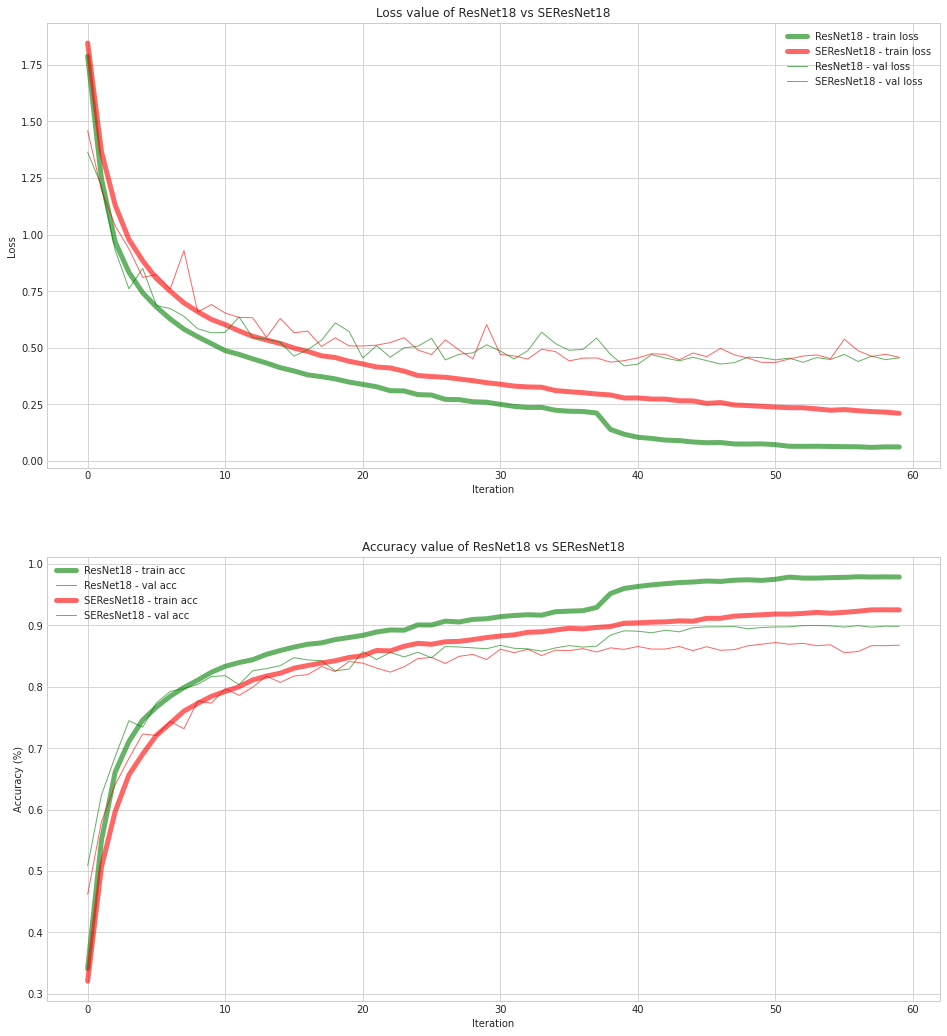

In [11]:
import pickle
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

fig, ax = plt.subplots(2, figsize=(16,18))
with open("./result-20210129-104310/resnet18_adam_0.01_train_loss.txt", 'rb') as handle:
    data = pickle.load(handle)
    ax[0].plot(data, label="ResNet18 - train loss", c='g', lw=5, alpha=0.6)

with open("./result-20210129-104338/seresnet18_adam_0.01_train_loss.txt", 'rb') as handle:
    data = pickle.load(handle)
    ax[0].plot(data, label="SEResNet18 - train loss", c='r', lw=5, alpha=0.6)

with open("./result-20210129-104310/resnet18_adam_0.01_val_loss.txt", 'rb') as handle:
    data = pickle.load(handle)
    ax[0].plot(data, label="ResNet18 - val loss", c='g', lw=1, alpha=0.6)

with open("./result-20210129-104338/seresnet18_adam_0.01_val_loss.txt", 'rb') as handle:
    data = pickle.load(handle)
    ax[0].plot(data, label="SEResNet18 - val loss", c='r', lw=1, alpha=0.6)

ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss value of ResNet18 vs SEResNet18')
ax[0].legend()

with open("./result-20210129-104310/resnet18_adam_0.01_train_acc.txt", 'rb') as handle:
    data = pickle.load(handle)
    ax[1].plot(data, label="ResNet18 - train acc", c='g', lw=5, alpha=0.6)
with open("./result-20210129-104310/resnet18_adam_0.01_val_acc.txt", 'rb') as handle:
    data = pickle.load(handle)
    ax[1].plot(data, label="ResNet18 - val acc", c='g', lw=1, alpha=0.6)

with open("./result-20210129-104338/seresnet18_adam_0.01_train_acc.txt", 'rb') as handle:
    data = pickle.load(handle)
    ax[1].plot(data, label="SEResNet18 - train acc", c='r', lw=5, alpha=0.6)
with open("./result-20210129-104338/seresnet18_adam_0.01_val_acc.txt", 'rb') as handle:
    data = pickle.load(handle)
    ax[1].plot(data, label="SEResNet18 - val acc", c='r', lw=1, alpha=0.6)

ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title('Accuracy value of ResNet18 vs SEResNet18')
ax[1].legend()

plt.show()

## 4. Chihuahua VS Muffin
1. I download the imagenet chihuahua and muffin images and put them in ./data/imagenet/chihuahua and ./data/imagenet/muffin
 - http://image-net.org/synset?wnid=n02085620 : 1750 Chihuahua
 - http://image-net.org/synset?wnid=n07690273 : 1335 muffins
 - Although there are 1750+1335 images in total, it mixed with broken links and corrupted images. Therefore, there are only 1988 images in which 899 are chihuahua and 1089 are muffin
2. I download the kaggle chihuahua and muffin, perform horizontal flip, and put them in the ./data/kaggle/chihuahua and ./data/kaggle/chihuahua
 - There 8 images of chihuahua and another 8 images of muffin.
 - After flipping, there are 16 of each.
3. The tranformation are the same as above.
4. The configuration are the same as above except that I use <code>ReduceLROnPlateau</code> with patience of 5
5. Pretrain SEResNet from CIFAR-10 is modified so that the last layer output 2 classes
6. I perform 3 different experiments.

### 4.1 8Fold cross validation

This experiment is aimed to practice transfer learning on small dataset, in this case, our kaggel 32 images.

1. I use <code>from sklearn.model_selection import KFold</code> to generate 8 different train/val dataset.
2. Since both class is balanced and easy to implement. I generate 8 folds using index range of 1-16. Then, for each index fold, I append itself with itself + 16 which yeild me a balanced fold.
3. Surprisingly, all fold achived 100 training/validation accuracy.


### 4.2 Train on ImageNet - Test on Kaggle

In fact, this is my first experiment since I misunderstood that kaggle dataset will be used for testing purposed.
As shown in the below figure, the model can predict chihuahua and muffin well over 90% since with out training. But, the model only gain 2-3% more accuracy after training.

===== Testing =====

- Accuracy of the network on the 16 test images: 87 %
- Accuracy of chihuahua : 100 %
- Accuracy of muffin : 75 %



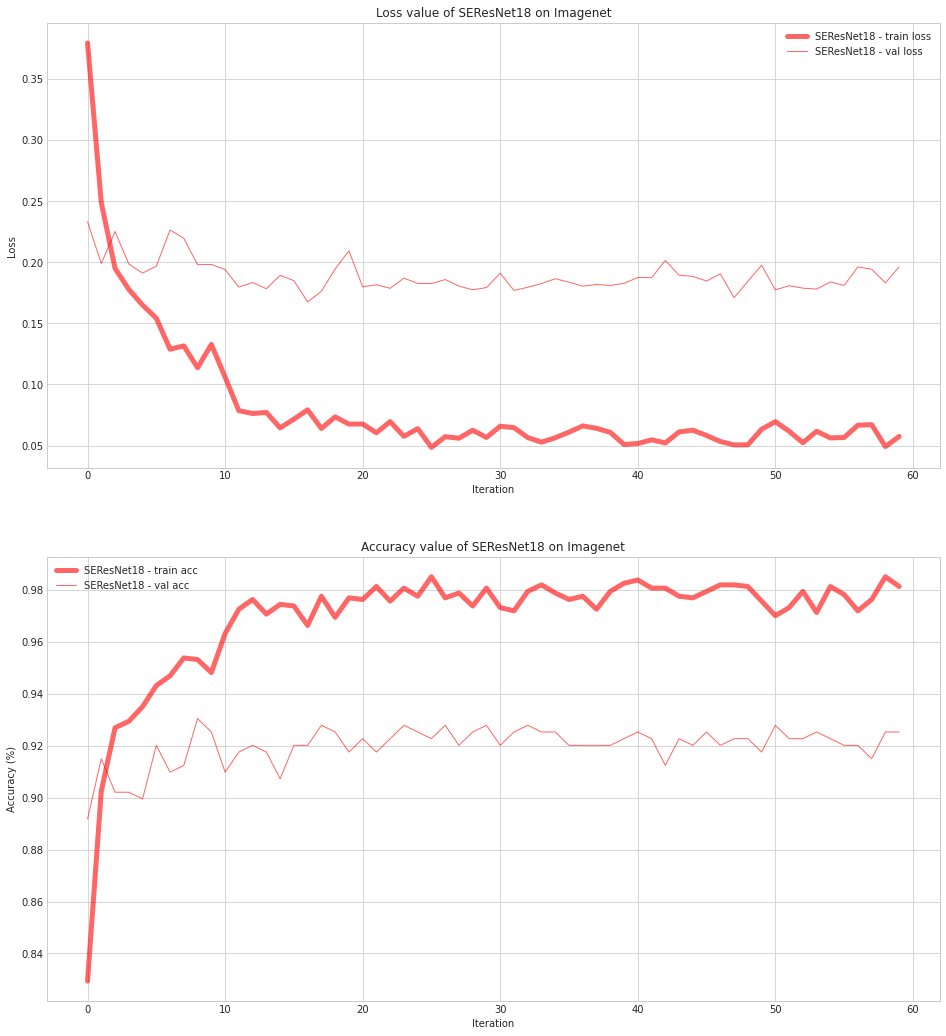

In [12]:
fig, ax = plt.subplots(2, figsize=(16,18))

with open("./result-chihuahuaVSmuffin_imagenet/seresnet18_chihuahua_muffin_adam_0.01_train_loss.txt", 'rb') as handle:
    data = pickle.load(handle)
    ax[0].plot(data, label="SEResNet18 - train loss", c='r', lw=5, alpha=0.6)


with open("./result-chihuahuaVSmuffin_imagenet/seresnet18_chihuahua_muffin_adam_0.01_val_loss.txt", 'rb') as handle:
    data = pickle.load(handle)
    ax[0].plot(data, label="SEResNet18 - val loss", c='r', lw=1, alpha=0.6)

ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss value of SEResNet18 on Imagenet')
ax[0].legend()


with open("./result-chihuahuaVSmuffin_imagenet/seresnet18_chihuahua_muffin_adam_0.01_train_acc.txt", 'rb') as handle:
    data = pickle.load(handle)
    ax[1].plot(data, label="SEResNet18 - train acc", c='r', lw=5, alpha=0.6)
with open("./result-chihuahuaVSmuffin_imagenet/seresnet18_chihuahua_muffin_adam_0.01_val_acc.txt", 'rb') as handle:
    data = pickle.load(handle)
    ax[1].plot(data, label="SEResNet18 - val acc", c='r', lw=1, alpha=0.6)

ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title('Accuracy value of SEResNet18 on Imagenet')
ax[1].legend()

plt.show()

### 4.3 Train on Kaggle - Test on ImageNet

Just for fun and curiosity, I perform full training on 32 kaggle images and test on imagenet dataset.

With little surprise, the model achive 100% accuracy on kaggle during training and validation. 
But when we testing on imagenet dataset, it fails to detect chihuahua.

The problem could be that, in Kaggle, both chihuahua and muffin are brown but in ImageNet, it is a mix colour of Chihuahua and Muffin. The failure could be due to different in colour not the shape.

In [ ]:
# Epoch 29/29:LR: 0.01
# ----------
# train Loss: 0.0026 Acc: 1.0000
# Epoch time taken:  0.2746086120605469
# val Loss: 0.0004 Acc: 1.0000
# Epoch time taken:  0.4482100009918213
# Training complete in 0m 14s
# Best val Acc: 1.000000
# ===== Testing =====
# Accuracy of the network on the 1988 test images: 63 %
# Accuracy of chihuahua : 46 %
# Accuracy of muffin : 77 %

To verified this I modified my transformation with greyscale

In [ ]:
preprocess_augment = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])

I did the experiment twice with different Normalized mean and std.
The result of both experiments is no where near the same.

Using the magic mean and std, The model is slightly worst than the colour classifier when only look at the total accuracy.
But when we look at the per class accuracy, the model can classify muffin near perfect but fail to detect chihuahua.


In [ ]:
mean, std = (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)

# Epoch 29/29:LR: 0.01
# ----------
# train Loss: 0.0034 Acc: 1.0000
# Epoch time taken:  0.21899080276489258
# val Loss: 0.0011 Acc: 1.0000
# Epoch time taken:  0.3461124897003174
# Training complete in 0m 12s
# Best val Acc: 1.000000
# ===== Testing =====
# Accuracy of the network on the 1988 test images: 58 %
# Accuracy of chihuahua : 14 %
# Accuracy of muffin : 95 %

Using mean and std of 0.5 accross, the model is slightly worst than the colour counterpart but now the model hesitate between chihuahua and muffin.

In [ ]:
mean, std = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

# Epoch 29/29:LR: 0.01
# ----------
# train Loss: 0.0302 Acc: 1.0000
# Epoch time taken:  0.22031545639038086
# val Loss: 0.0015 Acc: 1.0000
# Epoch time taken:  0.34909915924072266
# Training complete in 0m 12s
# Best val Acc: 1.000000
# ===== Testing =====
# Accuracy of the network on the 1988 test images: 61 %
# Accuracy of chihuahua : 65 %
# Accuracy of muffin : 57 %